In [41]:
# библиотеки
import numpy as np
import time
import os
import vrplib
import re
import shutil
from sklearn.model_selection import ParameterGrid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

### Класс реализации алгоритма поиска оптимального решения

In [42]:
class AntColonyOptimizer:
    def __init__(self, nodes, demands, vehicle_capacity, alpha, beta, iterations_without_improvement):
        self.nodes = nodes  # список узлов с координатами (id, x, y)
        self.demands = demands  # список спроса для каждого узла, спрос депо установлен в 0
        self.vehicle_capacity = vehicle_capacity  # вместимость транспортного средства
        self.alpha = alpha  # важность феромона
        self.beta = beta  # важность видимости (инверсия расстояния)
        self.iterations_without_improvement = iterations_without_improvement  # критерий остановки алгоритма
        self.num_nodes = len(nodes)  # количество узлов
        self.distance_matrix = self.calculate_distance_matrix(nodes)  # матрица расстояний между узлами
        self.pheromone_matrix = self.initialize_pheromone_matrix()  # матрица феромонов
        self.best_route = None  # лучший маршрут
        self.best_distance = float('inf')  # лучшее расстояние

    # Расчет матрицы расстояний между узлами
    def calculate_distance_matrix(self, nodes):
        num_nodes = len(nodes)
        distance_matrix = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j: 
                    distance_matrix[i][j] = np.linalg.norm(np.array(self.nodes[i]) - np.array(self.nodes[j]))
        return distance_matrix

    # Инициализация матрицы феромонов
    def initialize_pheromone_matrix(self):
        non_zero_demands = [demand for demand in self.demands if demand > 0]
        tau_0 = 1 / ((self.num_nodes - 1) * min(non_zero_demands)) if non_zero_demands else 0
        pheromone_matrix = np.ones((self.num_nodes, self.num_nodes)) * tau_0
        np.fill_diagonal(pheromone_matrix, 0)
        return pheromone_matrix

    # Расчет вероятностей выбора следующего узла
    def probability_of_choice(self, ant_location, unvisited_nodes):
        probabilities = np.zeros(len(unvisited_nodes))
        for i, node in enumerate(unvisited_nodes):
            if self.distance_matrix[ant_location][node] > 0:
                pheromone = self.pheromone_matrix[ant_location][node] ** self.alpha
                inverse_distance = (1 / self.distance_matrix[ant_location][node]) ** self.beta
                probabilities[i] = pheromone * inverse_distance

        sum_probabilities = np.sum(probabilities)
        if sum_probabilities > 0:
            probabilities /= sum_probabilities
        else:
            probabilities = np.ones(len(unvisited_nodes)) / len(unvisited_nodes)
        return probabilities

    # Выбор следующего узла на основе расчитанных вероятностей
    def find_next_node(self, ant_location, unvisited_nodes):
        probabilities = self.probability_of_choice(ant_location, unvisited_nodes)
        next_node = np.random.choice(unvisited_nodes, p=probabilities)
        return next_node

    # Локальное обновление феромона
    def local_pheromone_update(self, ant_location, next_node):
        self.pheromone_matrix[ant_location][next_node] *= (1 - self.alpha)
        self.pheromone_matrix[ant_location][next_node] += self.alpha * self.pheromone_matrix[ant_location][next_node]

    # Глобальное обновление феномона
    def global_pheromone_update(self, best_route, distance):
        # сброс феромона на всех путях
        self.pheromone_matrix *= (1 - self.alpha)
        # отложение феромона только на лучшем пути
        for i in range(len(best_route) - 1):
            if best_route[i] != 0 and best_route[i + 1] != 0:  # Исключаем переходы через депо
                self.pheromone_matrix[best_route[i]][best_route[i + 1]] += self.alpha * (1 / distance)
                
    # Cоздание маршрута муравьем
    def build_solution(self):
        route = [0]  # начало маршрута с депо
        current_load = 0
        unvisited_nodes = list(range(1, self.num_nodes))

        while unvisited_nodes:
            next_node = self.find_next_node(route[-1], unvisited_nodes)
            if current_load + self.demands[next_node] <= self.vehicle_capacity:
                current_load += self.demands[next_node]
                route.append(next_node)
                unvisited_nodes.remove(next_node)
                self.local_pheromone_update(route[-2], next_node)
            else:
                # возвращение в депо
                route.append(0)
                current_load = 0
        
        # окончание маршрута - депо
        if route[-1] != 0:
            route.append(0)
        
        return route

    # Оптимизация маршрута
    def optimize(self):
        num_iterations_no_improvement = 0
        while num_iterations_no_improvement < self.iterations_without_improvement:
            current_route = self.build_solution()
            current_distance = self.calculate_route_distance(current_route)

            if current_distance < self.best_distance:
                self.best_route = current_route
                self.best_distance = current_distance
                num_iterations_no_improvement = 0
            else:
                num_iterations_no_improvement += 1

            self.global_pheromone_update(self.best_route, self.best_distance)

        return self.best_route, self.best_distance

    # Расчет общего расстояния маршрута
    def calculate_route_distance(self, route):
        distance = 0
        for i in range(len(route) - 1):
            distance += self.distance_matrix[route[i]][route[i + 1]]
        return distance


In [43]:
vrp_folder_a = './vrp/A/'
vrp_folder_b = './vrp/B/'
vrp_folder_e = './vrp/E/'
all_folder = './vrp/all/'

# Функция поиска всех файлов в папке
def find_txt_files(directory):
    txt_files = []
    sol_files = []
 
    for file in os.listdir(directory):
        if file.endswith(".vrp"):
            txt_files.append(file)
        if file.endswith(".sol"):
            sol_files.append(file)
            
    return txt_files, sol_files

# Функция для форматирования представления машрута
def format_route(path, demand):
    routes = []
    current_route = []
    current_demand = 0
    for node in path:
        if node == 0 and current_route:
            routes.append((current_route, current_demand))
            current_route = []
            current_demand = 0
        else:
            current_route.append(node)
            current_demand += demand[node]
    if current_route:
        routes.append((current_route, current_demand))

    return routes

vrp_files_a, sol_files_a = find_txt_files(vrp_folder_a)
vrp_files_b, sol_files_b = find_txt_files(vrp_folder_b)
vrp_files_e, sol_files_e = find_txt_files(vrp_folder_e)

# Копирование всех файлов в одну общую папку
for folder in [vrp_folder_a, vrp_folder_b, vrp_folder_e]:
    for filename in os.listdir(folder):
        source_file = os.path.join(folder, filename)
        if os.path.isfile(source_file):
            destination_file = os.path.join(all_folder, filename)
            shutil.copyfile(source_file, destination_file)

vrp_files_all = vrp_files_a + vrp_files_b + vrp_files_e
sol_files_all = sol_files_a + sol_files_b + sol_files_e


### Поиск наилучших параметров

In [44]:
param_grid = {
    'alpha': [0.3, 0.5, 0.9],
    'beta': range(1, 6, 1),
    'iterations': [100, 300, 500]
}

grid = list(ParameterGrid(param_grid))

min_average_difference = float('inf')
best_params = None
result = {}

for params in tqdm(grid, desc="Grid Search Progress"):
    average_difference = 0
    for i in range(len(vrp_files_all)):
        vrp_problem = vrplib.read_instance(all_folder + vrp_files_all[i])
        numbers = re.findall(r'\d+', vrp_problem['comment'])
        numbers_list = [int(num) for num in numbers]
        vrp_problem['No_of_trucks'] = numbers_list[-2]
        vrp_problem['Optimal_value'] = numbers_list[-1]
        if 'node_coord' in vrp_problem:
            a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=params['alpha'], beta=params['beta'], iterations_without_improvement=params['iterations'])
            best_solution, best_distance = a.optimize()
            optimal_value = vrp_problem['Optimal_value']
            average_difference += (best_distance - optimal_value) / optimal_value * 100

    average_difference /= len(vrp_files_a)
    result[str(params)] = average_difference
    if average_difference < min_average_difference:
        min_average_difference = average_difference
        best_params = params

print(f'Best Parameters: {best_params}')
print(f'Minimum Average Difference: {min_average_difference}%')

Grid Search Progress: 100%|██████████| 45/45 [41:20<00:00, 55.12s/it] 

Best Parameters: {'alpha': 0.3, 'beta': 5, 'iterations': 500}
Minimum Average Difference: 29.82363053555084%


### Лучшие параметры подобранные через GridSearch

In [45]:
best_params = {'alpha': 0.3, 'beta': 5, 'iterations_without_improvement': 500}

In [46]:
mean_diff_a, mean_diff_b, mean_diff_e = 0, 0, 0
mean_time_a, mean_time_b, mean_time_e = 0, 0, 0

### Тестирование на А (вывод точности и времени выполнения)

In [47]:
average_difference = 0
average_time = 0
accuracy_array_a = []
time_array_a = []

# Цикл по фалам в папке
for i in range(len(vrp_files_a)):
    vrp_problem = vrplib.read_instance(vrp_folder_a + vrp_files_a[i])
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    if 'node_coord' in vrp_problem.keys():
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        accuracy_array_a.append(current_difference)
        time_array_a.append(current_time)

        average_difference += current_difference
        average_time += current_time

mean_diff_a = average_difference/len(vrp_files_a)
mean_time_a = average_time/len(vrp_files_a)
print(f'Average Difference: {round(mean_diff_a, 2)}%')
print(f'Average time: {round(mean_time_a, 2)}s')

Average Difference: 13.87%
Average time: 1.14s


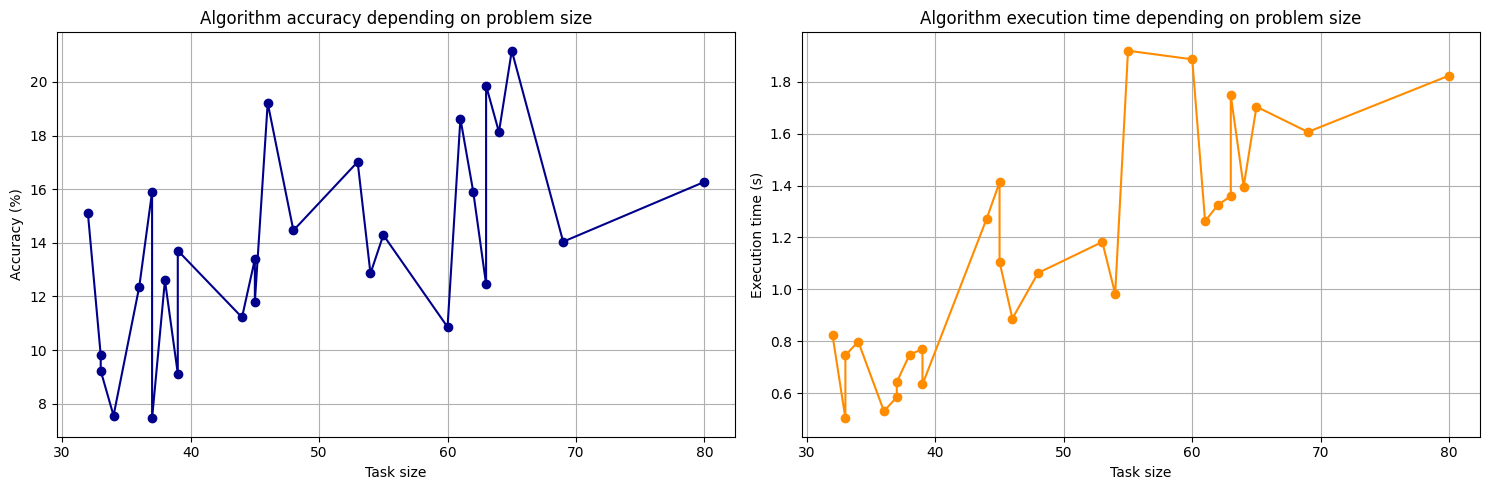

In [48]:
task_sizes_a = []
task_sizes_a.clear()
for filename in os.listdir(vrp_folder_a):
    match = re.search(r"A-n(\d+)-k\d+\.vrp", filename)
    if match:
        task_size = int(match.group(1))
        task_sizes_a.append(task_size)


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(task_sizes_a, accuracy_array_a, marker='o', linestyle='-', color='darkblue')
plt.title('Algorithm accuracy depending on problem size')
plt.xlabel('Task size')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(task_sizes_a, time_array_a, marker='o', linestyle='-', color='darkorange')
plt.title('Algorithm execution time depending on problem size')
plt.xlabel('Task size')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Тестирование на B (вывод точности и времени выполнения)

In [49]:
average_difference = 0
average_time = 0
accuracy_array_b = []
time_array_b = []
for i in range(len(vrp_files_b)):
    vrp_problem = vrplib.read_instance(vrp_folder_b + vrp_files_b[i])
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    if 'node_coord' in vrp_problem.keys():
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        accuracy_array_b.append(current_difference)
        time_array_b.append(current_time)

        average_difference += current_difference
        average_time += current_time

mean_diff_b = average_difference/len(vrp_files_b)
mean_time_b = average_time/len(vrp_files_b)
print(f'Average Difference: {round(mean_diff_b, 2)}%')
print(f'Average time: {round(mean_time_b, 2)}s')

Average Difference: 10.72%
Average time: 1.32s


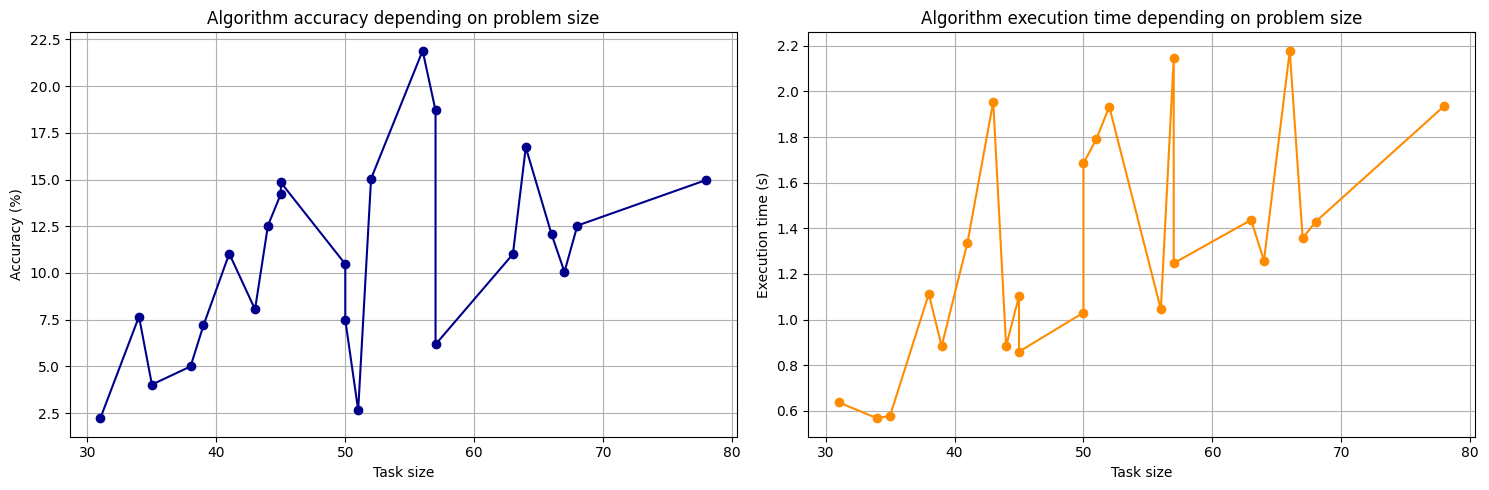

In [50]:
task_sizes_b = []
task_sizes_b.clear()

for filename in os.listdir(vrp_folder_b):
    match = re.search(r"B-n(\d+)-k\d+\.vrp", filename)
    if match:
        task_size = int(match.group(1))
        task_sizes_b.append(task_size)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(task_sizes_b, accuracy_array_b, marker='o', linestyle='-', color='darkblue')
plt.title('Algorithm accuracy depending on problem size')
plt.xlabel('Task size')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(task_sizes_b, time_array_b, marker='o', linestyle='-', color='darkorange')
plt.title('Algorithm execution time depending on problem size')
plt.xlabel('Task size')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Тестирование на E (вывод точности и времени выполнения)

In [51]:
task_sizes_e = []
task_sizes_e.clear()

for filename in os.listdir(vrp_folder_e):
    match = re.search(r"E-n(\d+)-k\d+\.vrp", filename)
    if match:
        task_size = int(match.group(1))
        task_sizes_e.append(task_size)

average_difference = 0
average_time = 0
accuracy_array_e = []
time_array_e = []
task_sizes_e2 = []

for i in range(len(vrp_files_e)):
    vrp_problem = vrplib.read_instance(vrp_folder_e + vrp_files_e[i])
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    if 'node_coord' in vrp_problem.keys():
        task_sizes_e2.append(task_sizes_e[i])
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        accuracy_array_e.append(current_difference)
        time_array_e.append(current_time)

        average_difference += current_difference
        average_time += current_time

mean_diff_e = average_difference/len(vrp_files_e)
mean_time_e = average_time/len(vrp_files_e)
print(f'Average Difference: {round(mean_diff_e, 2)}%')
print(f'Average time: {round(mean_time_e, 2)}s')

Average Difference: 12.19%
Average time: 1.45s


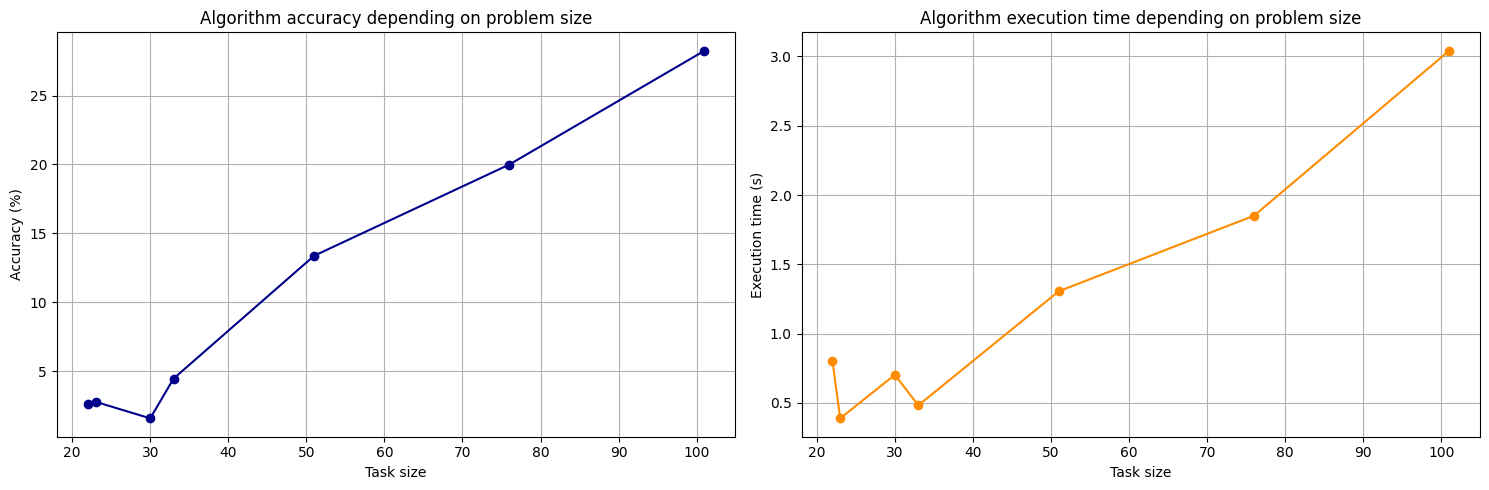

In [52]:
my_dict = {}
for key, value in zip(task_sizes_e2, accuracy_array_e):
    my_dict[key] = value

sorted_keys = sorted(my_dict.keys())
sorted_values = [my_dict[key] for key in sorted_keys]  

my_dict2 = {}
for key, value in zip(task_sizes_e2, time_array_e):
    my_dict2[key] = value

sorted_keys2 = sorted(my_dict2.keys())
sorted_values2 = [my_dict2[key] for key in sorted_keys2]    

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(sorted_keys, sorted_values, marker='o', linestyle='-', color='darkblue')
plt.title('Algorithm accuracy depending on problem size')
plt.xlabel('Task size')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sorted_keys2, sorted_values2, marker='o', linestyle='-', color='darkorange')
plt.title('Algorithm execution time depending on problem size')
plt.xlabel('Task size')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Тестирование на всех наборах (вывод точности и времени выполнения)

In [53]:
average_difference = 0
average_time = 0
accuracy_array_all = []
time_array_all = []

for i in range(len(vrp_files_all)):
    vrp_problem = vrplib.read_instance(all_folder + vrp_files_all[i])
    numbers = re.findall(r'\d+', vrp_problem['comment'])
    numbers_list = [int(num) for num in numbers]
    vrp_problem['No_of_trucks'] = numbers_list[-2]
    vrp_problem['Optimal_value'] = numbers_list[-1]
    if 'node_coord' in vrp_problem.keys():
        a = AntColonyOptimizer(vrp_problem['node_coord'], vrp_problem['demand'], vrp_problem['capacity'],
                                  alpha=best_params['alpha'], beta=best_params['beta'], iterations_without_improvement=best_params['iterations_without_improvement'])
        optimal_value = vrp_problem['Optimal_value']
        start_time = time.time()
        best_solution, best_distance = a.optimize()
        end_time = time.time()
        
        current_difference = (best_distance - optimal_value) / optimal_value * 100
        current_time = end_time - start_time

        accuracy_array_all.append(current_difference)
        time_array_all.append(current_time)

        average_difference += current_difference
        average_time += current_time

mean_diff_all = average_difference/len(vrp_files_all)
mean_time_all = average_time/len(vrp_files_all)
print(f'Average Difference: {round(mean_diff_all, 2)}%')
print(f'Average time: {round(mean_time_all, 2)}s')

Average Difference: 12.8%
Average time: 1.19s


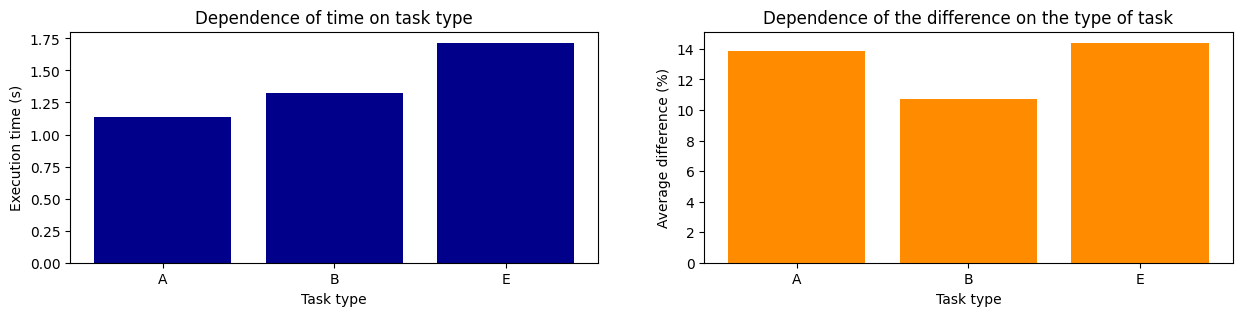

In [54]:
mean_diff_a = np.mean(accuracy_array_a)
mean_time_a = np.mean(time_array_a)

mean_diff_b = np.mean(accuracy_array_b)
mean_time_b = np.mean(time_array_b)

mean_diff_e = np.mean(accuracy_array_e)
mean_time_e = np.mean(time_array_e)

task_types = ['A', 'B', 'E']
times = [mean_time_a, mean_time_b, mean_time_e]
differences = [mean_diff_a, mean_diff_b, mean_diff_e]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
ax1.bar(task_types, times, color='darkblue')
ax1.set_xlabel('Task type')
ax1.set_ylabel('Execution time (s)')
ax1.set_title('Dependence of time on task type')

ax2.bar(task_types, differences, color='darkorange')
ax2.set_xlabel('Task type')
ax2.set_ylabel('Average difference (%)')
ax2.set_title('Dependence of the difference on the type of task')
plt.show()